# Exploring CSP Algorithms: The N-Queen's Problem

### Mehyar MLAWEH : mehyar.mlaweh@dauphine.tn
### Nadia BENYOUSSEF : nadia.benyoussef@dauphine.tn

### =======================================================================================

In [1]:
import time
import random

import matplotlib.pyplot as plt

from memory_profiler import memory_usage

import statistics as st

import copy

import os, psutil

### CSP Problem Formalization

In [2]:
class NQueensCSP:
    def __init__(self, N):
        self.N = N
        # Define the variables as the columns of the chessboard
        self.variables = list(range(N))
        # Set the domain of each variable to be the rows of the chessboard
        self.domains = {i: list(range(N)) for i in range(N)}
        # List of constraints
        self.constraints = []

        # Row constraint
        for i in range(N):
            for j in range(i + 1, N):
                self.constraints.append((i, j, lambda x, y: x != y))

        # Diagonal constraint
        for i in range(N):
            for j in range(i + 1, N):
                self.constraints.append((i, j, lambda x, y, i=i, j=j: abs(x - y) != abs(i - j)))

    def checkConstraint(self, var1, val1, var2, val2):
        for c in self.constraints:
            if (var1 == c[0] and var2 == c[1]) or (var1 == c[1] and var2 == c[0]):
                if not c[2](val1, val2):
                    return False
        # If no constraints are violated, return True
        return True

    def neighbors(self, var):
        return [v for v in self.variables if v != var]

In [3]:
#Testing The Formalization 
N = 2
csp = NQueensCSP(N)

# Test constraints
print("Testing :")
for i in range(N):
    for j in range(N):
        if i != j:
            for val1 in csp.domains[i]:
                for val2 in csp.domains[j]:
                    if not csp.checkConstraint(i, val1, j, val2):
                        print(f"Constraint NO: ({i}, {val1}) and ({j}, {val2})")
                    if csp.checkConstraint(i, val1, j, val2):
                        print(f"Constraint YES: ({i}, {val1}) and ({j}, {val2})")

print("Testing complete.")


Testing :
Constraint NO: (0, 0) and (1, 0)
Constraint NO: (0, 0) and (1, 1)
Constraint NO: (0, 1) and (1, 0)
Constraint NO: (0, 1) and (1, 1)
Constraint NO: (1, 0) and (0, 0)
Constraint NO: (1, 0) and (0, 1)
Constraint NO: (1, 1) and (0, 0)
Constraint NO: (1, 1) and (0, 1)
Testing complete.


### AC3 Algorithm

In [4]:
def revise(csp, Xi, Xj):
    revised = False
    for x in list(csp.domains[Xi]):
        if not any(csp.checkConstraint(Xi, x, Xj, y) for y in csp.domains[Xj]):
            csp.domains[Xi].remove(x)
            print("Removed value:", x, "from domain of", Xi)
            revised = True
    return revised

def ac3(csp, queue=None):
    if queue is None:
        queue = [(Xi, Xj) for Xi in csp.variables for Xj in csp.neighbors(Xi)]
    while queue:
        (Xi, Xj) = queue.pop(0)
        if revise(csp, Xi, Xj):
            print("Revise done")
            if len(csp.domains[Xi]) == 0:
                return False
            for Xk in csp.neighbors(Xi):
                if Xk != Xj:
                    queue.append((Xk, Xi))
    return True


### Testing AC3

In [5]:
N = 3
csp = NQueensCSP(N)
consistent = ac3(csp)  

if consistent:
    print("The CSP is consistent after applying AC3.")
else:
    print("The CSP is inconsistent after applying AC3.")


Removed value: 1 from domain of 0
Revise done
Removed value: 1 from domain of 1
Revise done
Removed value: 0 from domain of 2
Removed value: 2 from domain of 2
Revise done
Removed value: 1 from domain of 2
Revise done
The CSP is inconsistent after applying AC3.


### Evaluation

For N = 4:
Consistent? : True
Execution time: 0.0 seconds
Memory used during execution: 100.3125 MB
For N = 8:
Consistent? : True
Execution time: 0.0025179386138916016 seconds
Memory used during execution: 100.3203125 MB


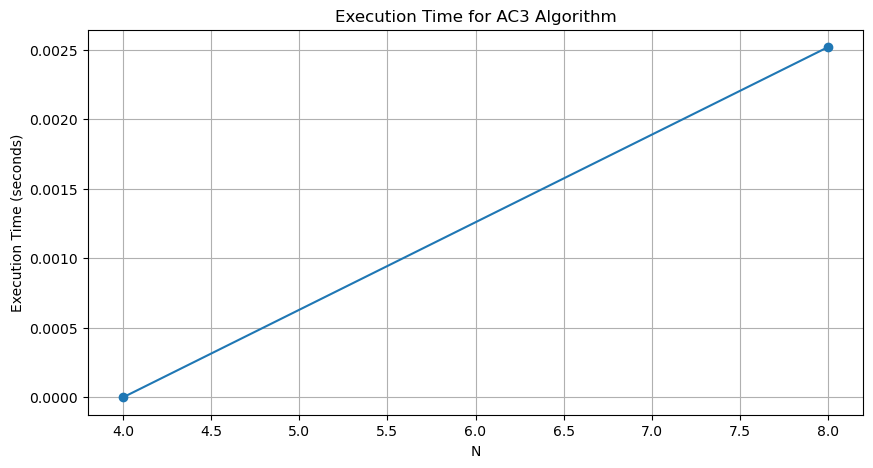

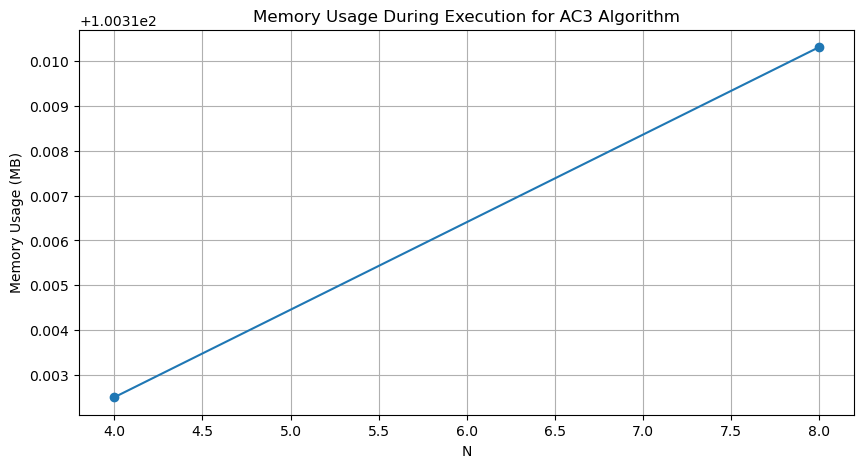

In [6]:
def test_ac3_for_n(N):
    start_time = time.time()

    csp = NQueensCSP(N)

    ac3_result = ac3(csp)

    end_time = time.time()
    execution_time = end_time - start_time

    end_memory = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2

    print(f"For N = {N}:")
    print("Consistent? :", ac3_result)
    print("Execution time:", execution_time, "seconds")
    print("Memory used during execution:", end_memory , "MB")

    return execution_time, end_memory 

Ns = [4, 8]
execution_times = []
memory_usages = []
for n in Ns:
    execution_time, memory_usage_during_execution = test_ac3_for_n(n)
    execution_times.append(execution_time)
    memory_usages.append(memory_usage_during_execution)

plt.figure(figsize=(10, 5))
plt.plot(Ns, execution_times, marker='o')
plt.title('Execution Time for AC3 Algorithm')
plt.xlabel('N')
plt.ylabel('Execution Time (seconds)')
plt.grid(True)
plt.show()

# Plot memory usage
plt.figure(figsize=(10, 5))
plt.plot(Ns, memory_usages, marker='o')
plt.title('Memory Usage During Execution for AC3 Algorithm')
plt.xlabel('N')
plt.ylabel('Memory Usage (MB)')
plt.grid(True)
plt.show()


### Depth-First Search with Backtracking

In [7]:
class DFS:
    def __init__(self, csp):
        self.csp = csp
        self.solutions = []

    def solve_all(self):
        """
        Method to find all solutions using depth-first search with backtracking.

        Returns:
            list: A list of all solutions found.
        """

        self.solutions = []  # Reset solutions list
        self.backtrack(0, [])  # Start the backtracking process from column 0
        return self.solutions  
    
    def backtrack(self, col, solution):
        """
        Recursive function to perform depth-first search with backtracking.

        Args:
            col (int): The current column being explored.
            solution (list): The current partial solution.

        Returns:
            None
        """

        # If all columns are explored (base case)
        if col == self.csp.N:
            # Add the solution to the list of solutions
            self.solutions.append(solution[:])
            return

        # Iterate over each possible row in the current column
        for row in self.csp.domains[col]:
            # Check if placing a queen in the current position is safe
            if self.is_safe(col, row, solution):
                # Place the queen in the current position
                solution.append(row)
                # Recursively move to the next column
                self.backtrack(col + 1, solution)
                # Backtrack by removing the last queen placed
                solution.pop()

    def is_safe(self, col, row, solution):
        """
        Method to check if placing a queen in a given position is safe.

        Args:
            col (int): The column of the queen being placed.
            row (int): The row of the queen being placed.
            solution (list): The current partial solution.

        Returns:
            bool: True if placing the queen is safe, False otherwise.
        """

        # Iterate over previously placed queens
        for prev_col, prev_row in enumerate(solution):
            # Check if the new queen conflicts with any previous queen
            if not self.csp.checkConstraint(col, row, prev_col, prev_row):
                return False
            # Check if the new queen is on the same diagonal as any previous queen
            if abs(col - prev_col) == abs(row - prev_row):
                return False
        return True

    def plot_chessboard(self, board):
        N = len(board)
        chessboard = [[(i + j) % 2 for i in range(N)] for j in range(N)]  # Generate a chessboard pattern

        fig, ax = plt.subplots()  # Create subplots
        ax.imshow(chessboard, cmap='binary')  # Plot the chessboard pattern

        # Plot queens on the chessboard
        for i in range(N):
            for j in range(N):
                if board[j] == i:  # If there is a queen in the position
                    # Plot the queen symbol
                    ax.text(j, i, u'\u265B', fontsize=30, ha='center', va='center', color='black' if (i + j) % 2 == 0 else 'white')

        ax.set_xticks([])  # Hide x-axis ticks
        ax.set_yticks([])  # Hide y-axis ticks
        plt.show()  # Show the plot

    def plot_solutions(self):
        for i, solution in enumerate(self.solutions):
            print(f"Solution {i + 1}:")
            self.plot_chessboard(solution)


### Testing DFS With Backtracking

Solution 1:


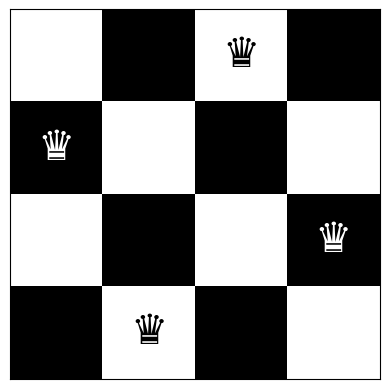

Solution 2:


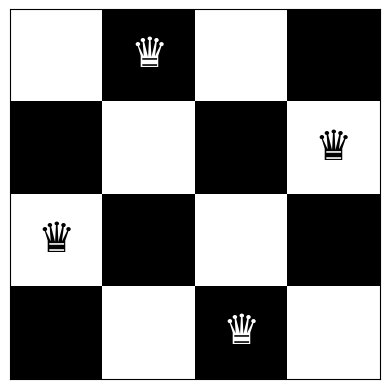

In [8]:
N = 4
csp = NQueensCSP(N) 
solver = DFS(csp)  
solutions = solver.solve_all()  
if(len(solutions)==0): 
    print("No solution")

solver.plot_solutions()


### Evaluation

For N = 4:
Number of solutions found: 2
Execution time: 0.0 seconds
Memory used during execution: 110.54296875 MB
For N = 6:
Number of solutions found: 4
Execution time: 0.0029633045196533203 seconds
Memory used during execution: 110.546875 MB
For N = 8:
Number of solutions found: 92
Execution time: 0.14200997352600098 seconds
Memory used during execution: 110.55078125 MB


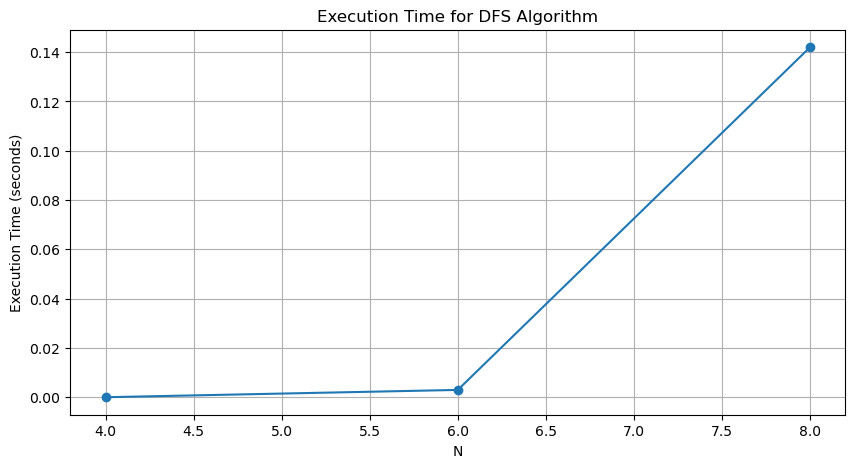

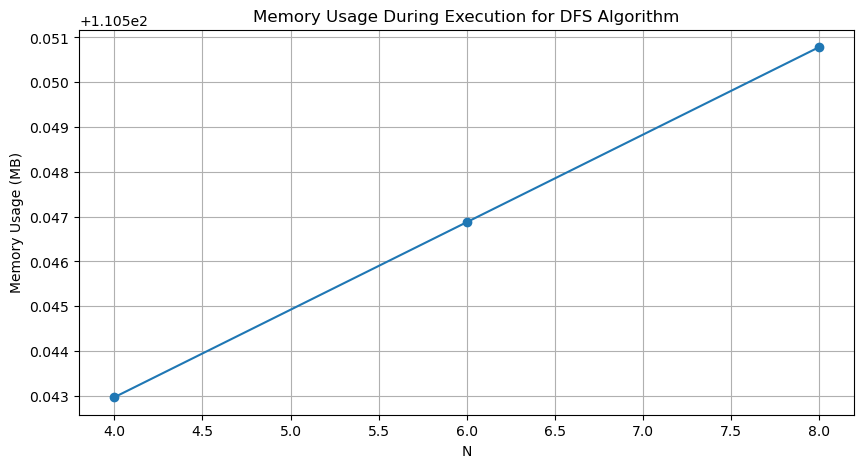

In [9]:
def test_dfs_for_n(N):
    start_time = time.time()

    # Create NQueensCSP instance
    csp = NQueensCSP(N)

    # Create DFS instance
    dfs_solver = DFS(csp)

    # Run DFS algorithm
    solutions = dfs_solver.solve_all()

    end_time = time.time()
    execution_time = end_time - start_time

    end_memory = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2

    print(f"For N = {N}:")
    print("Number of solutions found:", len(solutions))
    print("Execution time:", execution_time, "seconds")
    print("Memory used during execution:", end_memory, "MB")

    return execution_time, end_memory 

# Test for various values of N
Ns = [4,6, 8]
execution_times = []
memory_usages = []
for n in Ns:
    execution_time, memory_usage_during_execution = test_dfs_for_n(n)
    execution_times.append(execution_time)
    memory_usages.append(memory_usage_during_execution)

# Plot execution time
plt.figure(figsize=(10, 5))
plt.plot(Ns, execution_times, marker='o')
plt.title('Execution Time for DFS Algorithm')
plt.xlabel('N')
plt.ylabel('Execution Time (seconds)')
plt.grid(True)
plt.show()

# Plot memory usage
plt.figure(figsize=(10, 5))
plt.plot(Ns, memory_usages, marker='o')
plt.title('Memory Usage During Execution for DFS Algorithm')
plt.xlabel('N')
plt.ylabel('Memory Usage (MB)')
plt.grid(True)
plt.show()


### Forward Checking

In [10]:
class ForwardChecking:
    def __init__(self, csp):
        """
        Constructor for the ForwardChecking class.

        Args:
            csp: An instance of the CSP class representing the Constraint Satisfaction Problem.
        """
        self.csp = csp
        self.solutions = []

    def forward_checking(self):
        """
        Main method to perform forward checking and find all solutions.

        Returns:
            list: A list of all solutions found.
        """
        assignment = {}
        # Call the recursive forward checking method with the initial assignment
        self.solutions = self._recursive_forward_checking(assignment)
        return self.solutions

    def _recursive_forward_checking(self, assignment):
        """
        Recursive function to perform forward checking.

        Args:
            assignment (dict): A dictionary representing the current assignment of variables.

        Returns:
            list: A list of all solutions found from the current assignment.
        """
        # Base case: if all variables are assigned
        if len(assignment) == self.csp.N:
            return [assignment.copy()]  # Return the current assignment as a solution

        var = self.select_unassigned_variable(assignment)  # Select an unassigned variable
        solutions = []  # Initialize an empty list to store solutions

        if var is not None:  # Check if there is an unassigned variable
            for val in range(self.csp.N):  # Iterate over possible values for the variable
                if not self.violates_constraints(var, val, assignment):  # Check if value violates constraints
                    assignment[var] = val  # Assign the value to the variable
                    neighbors = self.get_neighbors(var, assignment)  # Get neighboring variables
                    forward_check = self._recursive_forward_checking(assignment)  # Recursively explore further assignments
                    solutions.extend(forward_check)  # Add solutions from further exploration
                    del assignment[var]  # Backtrack: remove the assigned value

        return solutions  # Return the list of solutions found

    def select_unassigned_variable(self, assignment):
        """
        Method to select an unassigned variable.

        Args:
            assignment (dict): A dictionary representing the current assignment of variables.

        Returns:
            int or None: The selected unassigned variable, or None if all variables are assigned.
        """
        unassigned_vars = [var for var in self.csp.variables if var not in assignment]
        if unassigned_vars:
            return min(unassigned_vars, key=lambda var: len(self.csp.domains[var]))
        else:
            return None

    def violates_constraints(self, var, value, assignment):
        """
        Method to check if assigning a value to a variable violates constraints.

        Args:
            var (int): The variable to assign a value to.
            value (int): The value to assign to the variable.
            assignment (dict): A dictionary representing the current assignment of variables.

        Returns:
            bool: True if the assignment violates constraints, False otherwise.
        """
        for constraint_var in assignment:
            if assignment[constraint_var] == value or abs(var - constraint_var) == abs(value - assignment[constraint_var]):
                return True
        return False

    def get_neighbors(self, var, assignment):
        """
        Method to get neighboring variables that are not yet assigned.

        Args:
            var (int): The variable to find neighbors for.
            assignment (dict): A dictionary representing the current assignment of variables.

        Returns:
            list: A list of neighboring variables.
        """
        return [neighbor for neighbor in self.csp.variables if neighbor != var and neighbor not in assignment]

    def restore_domains(self, neighbors, assignment):
        """
        Method to restore the domains of neighboring variables.

        Args:
            neighbors (list): A list of neighboring variables.
            assignment (dict): A dictionary representing the current assignment of variables.
        """
        for neighbor in neighbors:
            self.csp.domains[neighbor].extend([val for val in range(self.csp.N) if val not in self.csp.domains[neighbor]])

    def plot_chessboard(self, board):
        """
        Method to plot the chessboard with queens placed according to the solution.

        Args:
            board (list): A list representing the positions of queens on the chessboard.
        """
        N = len(board)
        chessboard = [[(i + j) % 2 for i in range(N)] for j in range(N)]

        fig, ax = plt.subplots()
        ax.imshow(chessboard, cmap='binary')

        for i in range(N):
            for j in range(N):
                if board[j] == i:
                    ax.text(j, i, u'\u265B', fontsize=30, ha='center', va='center', color='black' if (i + j) % 2 == 0 else 'white')

        ax.set_xticks([])
        ax.set_yticks([])
        plt.show()


### Testing FC

Solution 1:


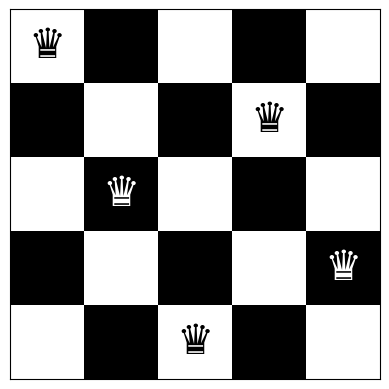

Solution 2:


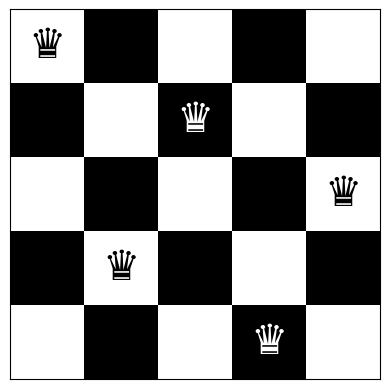

Solution 3:


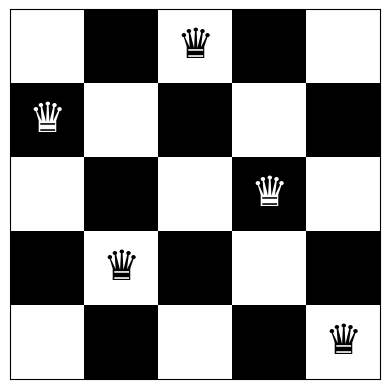

Solution 4:


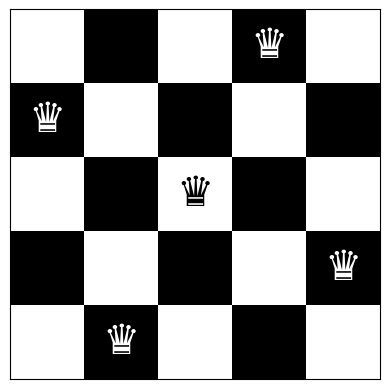

Solution 5:


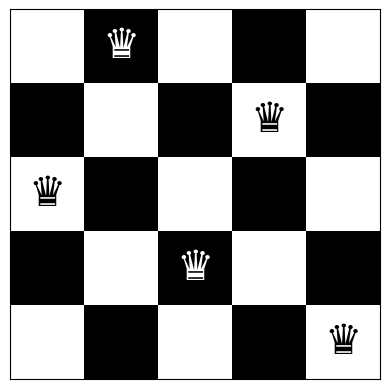

Solution 6:


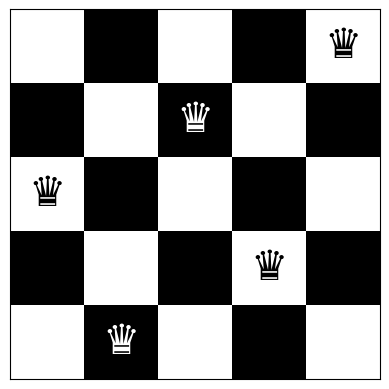

Solution 7:


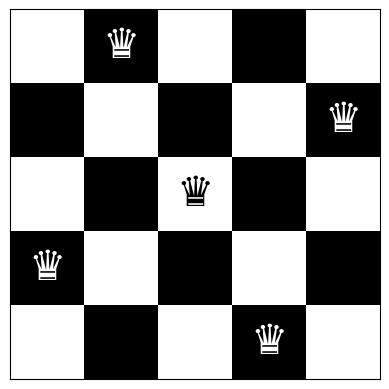

Solution 8:


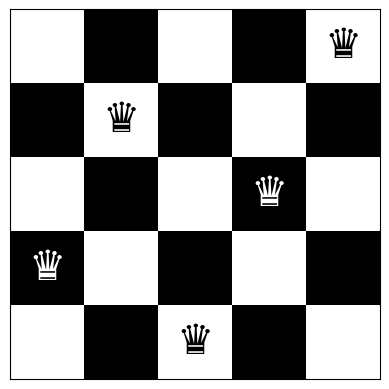

Solution 9:


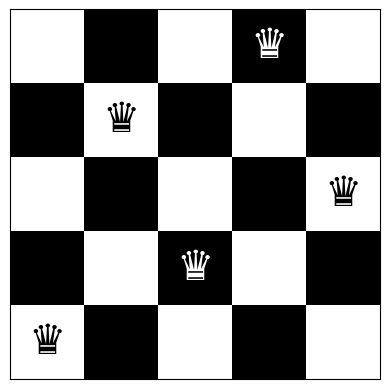

Solution 10:


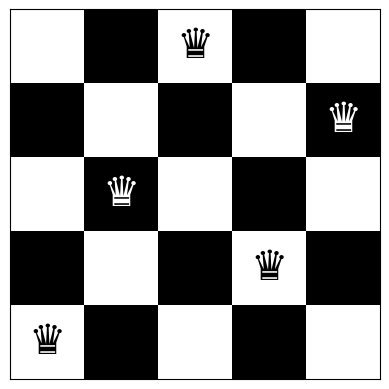

In [11]:
N = 5
csp = NQueensCSP(N)
forward_checker = ForwardChecking(csp)

solutions = forward_checker.forward_checking()
if solutions:
    for i, solution in enumerate(solutions):
        print(f"Solution {i + 1}:")
        forward_checker.plot_chessboard(solution)
else:
    print("No solution found")




### Evaluation

For N = 4:
Number of solutions found: 2
Execution time: 0.0 seconds
Memory used during execution: 115.79296875 MB
For N = 6:
Number of solutions found: 4
Execution time: 0.0 seconds
Memory used during execution: 115.79296875 MB
For N = 8:
Number of solutions found: 92
Execution time: 0.013200044631958008 seconds
Memory used during execution: 115.796875 MB


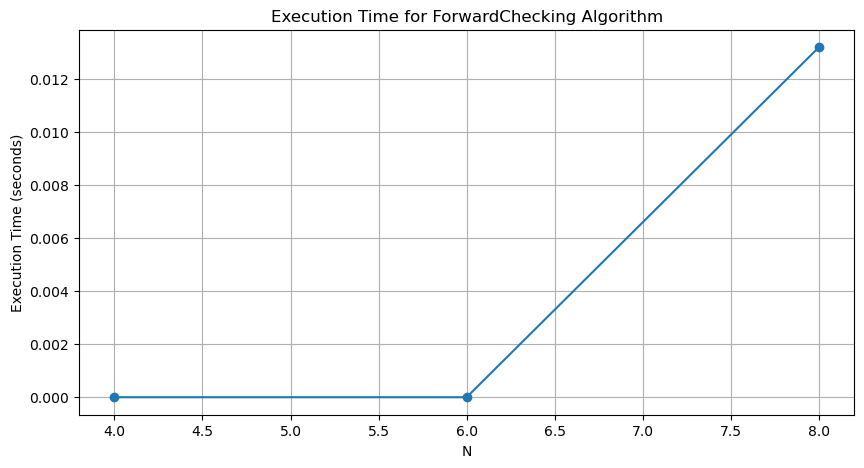

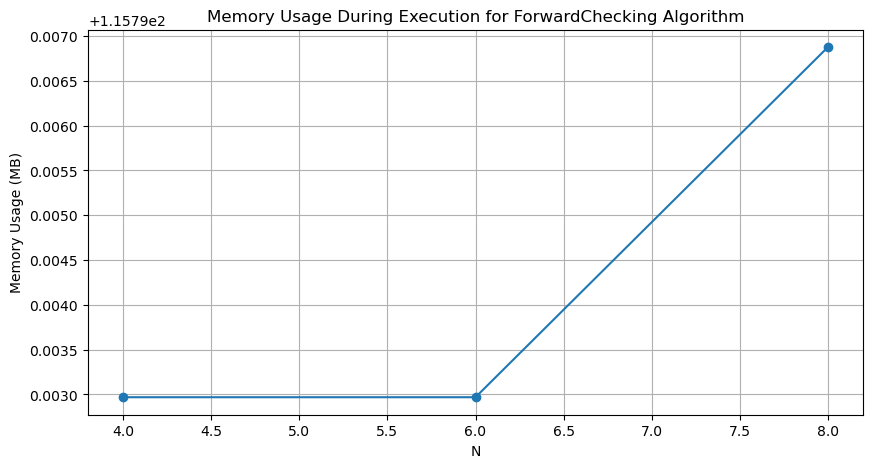

In [12]:
def test_forward_checking_for_n(N):
    start_time = time.time()

    # Create NQueensCSP instance
    csp = NQueensCSP(N)

    # Create ForwardChecking instance
    fc_solver = ForwardChecking(csp)

    # Run ForwardChecking algorithm
    solutions = fc_solver.forward_checking()

    end_time = time.time()
    execution_time = end_time - start_time

    end_memory = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2

    print(f"For N = {N}:")
    print("Number of solutions found:", len(solutions))
    print("Execution time:", execution_time, "seconds")
    print("Memory used during execution:", end_memory, "MB")

    return execution_time, end_memory 

# Test for various values of N
Ns = [4, 6,8]
execution_times = []
memory_usages = []
for n in Ns:
    execution_time, memory_usage_during_execution = test_forward_checking_for_n(n)
    execution_times.append(execution_time)
    memory_usages.append(memory_usage_during_execution)

# Plot execution time
plt.figure(figsize=(10, 5))
plt.plot(Ns, execution_times, marker='o')
plt.title('Execution Time for ForwardChecking Algorithm')
plt.xlabel('N')
plt.ylabel('Execution Time (seconds)')
plt.grid(True)
plt.show()

# Plot memory usage
plt.figure(figsize=(10, 5))
plt.plot(Ns, memory_usages, marker='o')
plt.title('Memory Usage During Execution for ForwardChecking Algorithm')
plt.xlabel('N')
plt.ylabel('Memory Usage (MB)')
plt.grid(True)
plt.show()


## DFS Using AC3

In [13]:
class DFSAC3:
    def __init__(self, csp):
        self.csp = csp
        self.solutions = []

    def solve_all(self):
        """
        Method to find all solutions using depth-first search with backtracking.

        Returns:
            list: A list of all solutions found.
        """

        self.solutions = []  
        reduced_domains = self.apply_ac3()  # Apply AC3 to get reduced domains
        self.backtrack(0, [], reduced_domains)  # Start the backtracking process from column 0
        return self.solutions  

    def apply_ac3(self):
        """
        Method to apply AC3 algorithm and obtain reduced domains for each variable.

        Returns:
            dict: A dictionary containing reduced domains for each variable.
        """
        ac3(self.csp)  # Apply AC3
        reduced_domains = {var: self.csp.domains[var] for var in self.csp.variables}
        return reduced_domains
    
    def backtrack(self, col, solution, reduced_domains):
        """
        Recursive function to perform depth-first search with backtracking.

        Args:
            col (int): The current column being explored.
            solution (list): The current partial solution.
            reduced_domains (dict): Reduced domains for each variable.

        Returns:
            None
        """

        # If all columns are explored (base case)
        if col == self.csp.N:
            # Add the solution to the list of solutions
            self.solutions.append(solution[:])
            return

        # Iterate over each possible row in the current column
        for row in reduced_domains[col]:
            # Check if placing a queen in the current position is safe
            if self.is_safe(col, row, solution):
                # Place the queen in the current position
                solution.append(row)
                # Recursively move to the next column
                self.backtrack(col + 1, solution, reduced_domains)
                # Backtrack by removing the last queen placed
                solution.pop()

    def is_safe(self, col, row, solution):
        """
        Method to check if placing a queen in a given position is safe.

        Args:
            col (int): The column of the queen being placed.
            row (int): The row of the queen being placed.
            solution (list): The current partial solution.

        Returns:
            bool: True if placing the queen is safe, False otherwise.
        """

        # Iterate over previously placed queens
        for prev_col, prev_row in enumerate(solution):
            # Check if the new queen conflicts with any previous queen
            if not self.csp.checkConstraint(col, row, prev_col, prev_row):
                return False
            # Check if the new queen is on the same diagonal as any previous queen
            if abs(col - prev_col) == abs(row - prev_row):
                return False
        return True

    def plot_chessboard(self, board):
        N = len(board)
        chessboard = [[(i + j) % 2 for i in range(N)] for j in range(N)]  # Generate a chessboard pattern

        fig, ax = plt.subplots()  # Create subplots
        ax.imshow(chessboard, cmap='binary')  # Plot the chessboard pattern

        # Plot queens on the chessboard
        for i in range(N):
            for j in range(N):
                if board[j] == i:  # If there is a queen in the position
                    # Plot the queen symbol
                    ax.text(j, i, u'\u265B', fontsize=30, ha='center', va='center', color='black' if (i + j) % 2 == 0 else 'white')

        ax.set_xticks([])  # Hide x-axis ticks
        ax.set_yticks([])  # Hide y-axis ticks
        plt.show()  # Show the plot

    def plot_solutions(self):
        for i, solution in enumerate(self.solutions):
            print(f"Solution {i + 1}:")
            self.plot_chessboard(solution)



### Testing DFSAC3

Solution 1:


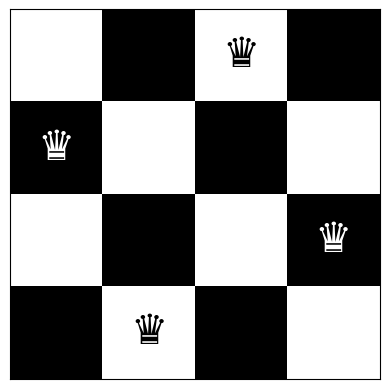

Solution 2:


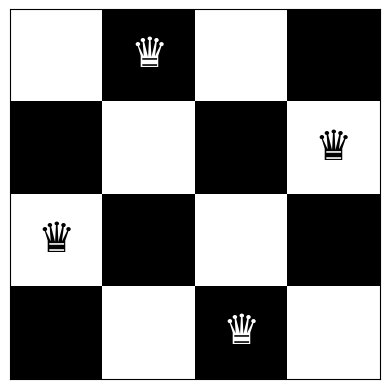

In [14]:
N = 4 
csp = NQueensCSP(N)
dfsac3 = DFSAC3(csp)
solutions = dfsac3.solve_all()
dfsac3.plot_solutions()


### Evaluation

For N = 4:
Number of solutions found: 2
Execution time: 0.0 seconds
Memory used during execution: 109.8359375 MB
For N = 6:
Number of solutions found: 4
Execution time: 0.0027303695678710938 seconds
Memory used during execution: 109.8359375 MB
For N = 8:
Number of solutions found: 92
Execution time: 0.14325475692749023 seconds
Memory used during execution: 109.8359375 MB


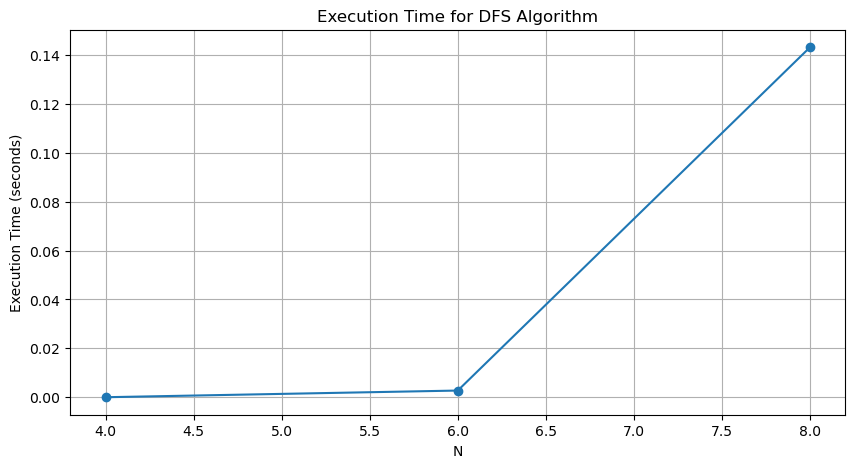

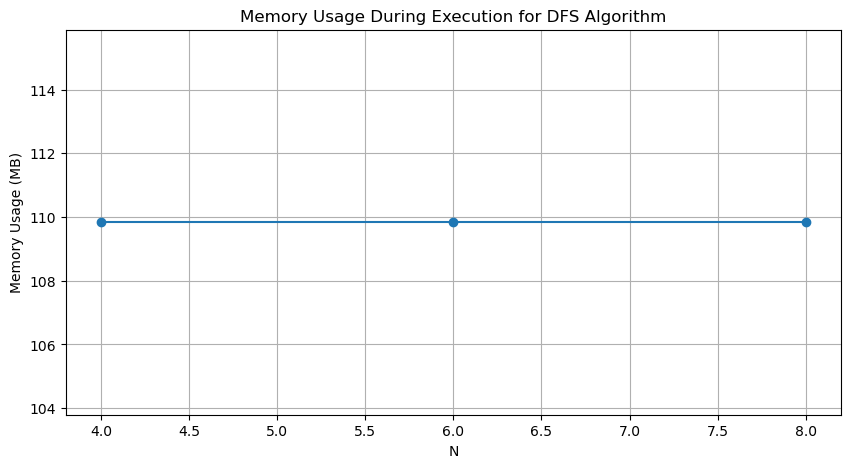

In [15]:
def test_dfsac3_for_n(N):
    start_time = time.time()

    # Create NQueensCSP instance
    csp = NQueensCSP(N)

    # Create DFS instance
    dfs_ac3 = DFSAC3(csp)

    # Run DFS algorithm
    solutions = dfs_ac3.solve_all()

    end_time = time.time()
    execution_time = end_time - start_time

    end_memory = psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2

    print(f"For N = {N}:")
    print("Number of solutions found:", len(solutions))
    print("Execution time:", execution_time, "seconds")
    print("Memory used during execution:", end_memory, "MB")

    return execution_time, end_memory 

# Test for various values of N
Ns = [4, 6, 8]
execution_times = []
memory_usages = []
for n in Ns:
    execution_time, memory_usage_during_execution = test_dfs_for_n(n)
    execution_times.append(execution_time)
    memory_usages.append(memory_usage_during_execution)

# Plot execution time
plt.figure(figsize=(10, 5))
plt.plot(Ns, execution_times, marker='o')
plt.title('Execution Time for DFS Algorithm')
plt.xlabel('N')
plt.ylabel('Execution Time (seconds)')
plt.grid(True)
plt.show()

# Plot memory usage
plt.figure(figsize=(10, 5))
plt.plot(Ns, memory_usages, marker='o')
plt.title('Memory Usage During Execution for DFS Algorithm')
plt.xlabel('N')
plt.ylabel('Memory Usage (MB)')
plt.grid(True)
plt.show()


## Results (Simple DFS vs. FC)

DFS===========================
For N = 2:
Number of solutions found: 0
Execution time: 0.0 seconds
Memory used during execution: 113.8046875 MB
For N = 4:
Number of solutions found: 2
Execution time: 0.0 seconds
Memory used during execution: 113.8046875 MB
For N = 6:
Number of solutions found: 4
Execution time: 0.004258155822753906 seconds
Memory used during execution: 113.8046875 MB
For N = 8:
Number of solutions found: 92
Execution time: 0.14175128936767578 seconds
Memory used during execution: 113.8046875 MB
For N = 10:
Number of solutions found: 724
Execution time: 6.121318817138672 seconds
Memory used during execution: 113.8046875 MB
For N = 12:
Number of solutions found: 14200
Execution time: 311.94930124282837 seconds
Memory used during execution: 113.48828125 MB
For N = 13:
Number of solutions found: 73712
Execution time: 2381.305305957794 seconds
Memory used during execution: 99.90625 MB
FORWAD CHECKING===============
For N = 2:
Number of solutions found: 0
Execution time: 0.0

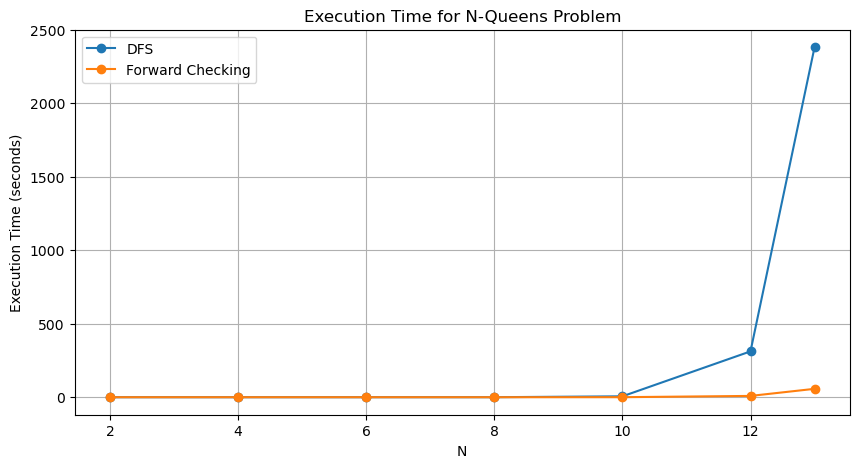

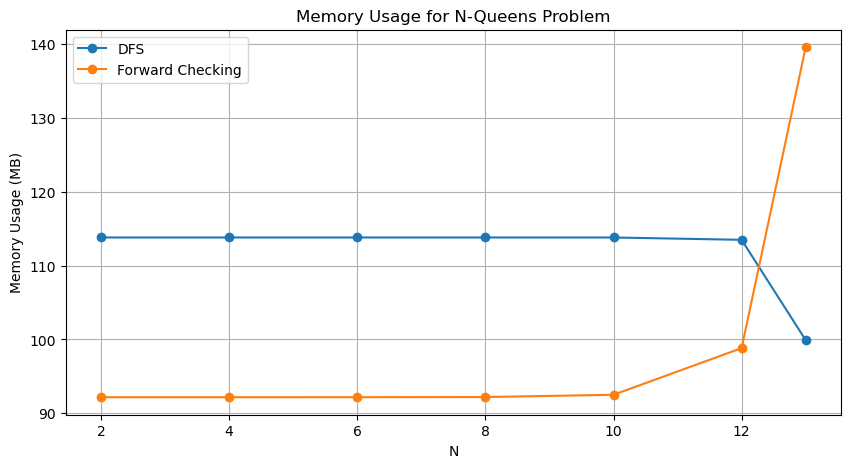

In [16]:
Ns = [2,4,6,8,10,12,13] 


print("DFS===========================")
dfs_execution_times = []
dfs_memory_usages = []
for n in Ns:
    execution_time1, memory_usage_during_execution1 = test_dfs_for_n(n)
    dfs_execution_times.append(execution_time1)
    dfs_memory_usages.append(memory_usage_during_execution1)
print("FORWAD CHECKING===============")
fc_execution_times = []
fc_memory_usages = []
for n in Ns:
    execution_time2, memory_usage_during_execution2 = test_forward_checking_for_n(n)
    fc_execution_times.append(execution_time2)
    fc_memory_usages.append(memory_usage_during_execution2)



plt.figure(figsize=(10, 5))
plt.plot(Ns, dfs_execution_times, marker='o', label='DFS')
plt.plot(Ns, fc_execution_times, marker='o', label='Forward Checking')
plt.title('Execution Time for N-Queens Problem')
plt.xlabel('N')
plt.ylabel('Execution Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(Ns, dfs_memory_usages, marker='o', label='DFS')
plt.plot(Ns, fc_memory_usages, marker='o', label='Forward Checking')
plt.title('Memory Usage for N-Queens Problem')
plt.xlabel('N')
plt.ylabel('Memory Usage (MB)')
plt.legend()
plt.grid(True)
plt.show()


## Results ( DFS_AC3 vs. FC)

DFS WITH AC3====================== 
Removed value: 0 from domain of 0
Removed value: 1 from domain of 0
Revise done
For N = 2:
Number of solutions found: 0
Execution time: 0.0 seconds
Memory used during execution: 96.98046875 MB
For N = 4:
Number of solutions found: 2
Execution time: 0.0 seconds
Memory used during execution: 96.98828125 MB
For N = 6:
Number of solutions found: 4
Execution time: 0.005510807037353516 seconds
Memory used during execution: 96.98828125 MB
For N = 8:
Number of solutions found: 92
Execution time: 0.14151787757873535 seconds
Memory used during execution: 96.99609375 MB
For N = 10:
Number of solutions found: 724
Execution time: 6.204867362976074 seconds
Memory used during execution: 95.49609375 MB
For N = 12:
Number of solutions found: 14200
Execution time: 317.35110306739807 seconds
Memory used during execution: 95.484375 MB
For N = 13:
Number of solutions found: 73712
Execution time: 2422.606921195984 seconds
Memory used during execution: 98.64453125 MB
FORWA

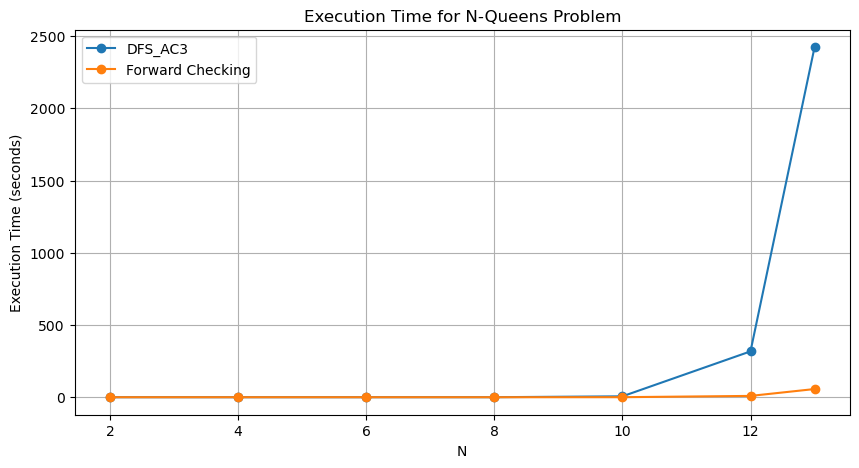

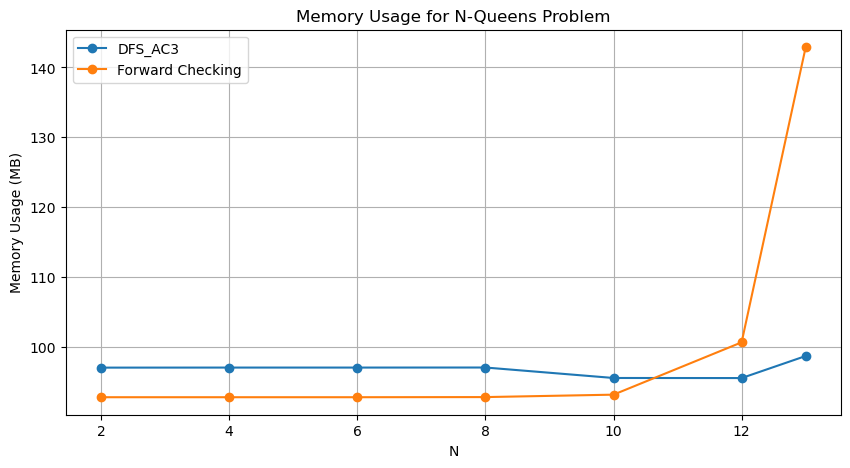

In [17]:
Ns = [2,4,6,8,10,12,13] 


    
print("DFS WITH AC3====================== ")
dfsac3_execution_times = []
dfsac3_memory_usages = []
for n in Ns:
    execution_time3, memory_usage_during_execution3 = test_dfsac3_for_n(n)
    dfsac3_execution_times.append(execution_time3)
    dfsac3_memory_usages.append(memory_usage_during_execution3)

print("FORWAD CHECKING===================")
fc_execution_times = []
fc_memory_usages = []
for n in Ns:
    execution_time4, memory_usage_during_execution4 = test_forward_checking_for_n(n)
    fc_execution_times.append(execution_time4)
    fc_memory_usages.append(memory_usage_during_execution4)



plt.figure(figsize=(10, 5))
plt.plot(Ns, dfsac3_execution_times, marker='o', label='DFS_AC3')
plt.plot(Ns, fc_execution_times, marker='o', label='Forward Checking')
plt.title('Execution Time for N-Queens Problem')
plt.xlabel('N')
plt.ylabel('Execution Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(Ns, dfsac3_memory_usages, marker='o', label='DFS_AC3')
plt.plot(Ns, fc_memory_usages, marker='o', label='Forward Checking')
plt.title('Memory Usage for N-Queens Problem')
plt.xlabel('N')
plt.ylabel('Memory Usage (MB)')
plt.legend()
plt.grid(True)
plt.show()


## DFS vs DFS_AC3

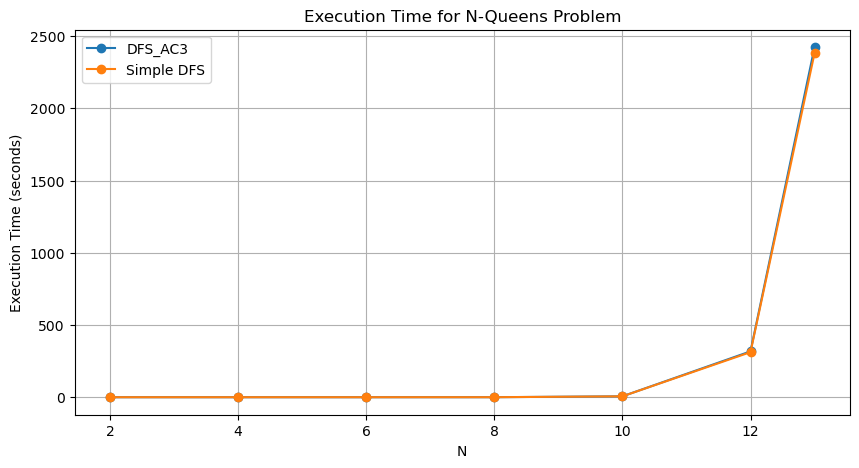

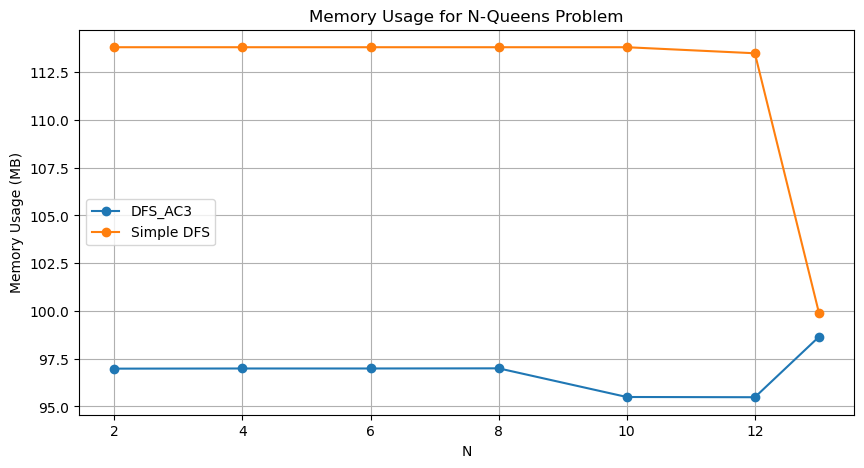

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(Ns, dfsac3_execution_times, marker='o', label='DFS_AC3')
plt.plot(Ns, dfs_execution_times, marker='o', label='Simple DFS')
plt.title('Execution Time for N-Queens Problem')
plt.xlabel('N')
plt.ylabel('Execution Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(Ns, dfsac3_memory_usages, marker='o', label='DFS_AC3')
plt.plot(Ns, dfs_memory_usages, marker='o', label='Simple DFS')
plt.title('Memory Usage for N-Queens Problem')
plt.xlabel('N')
plt.ylabel('Memory Usage (MB)')
plt.legend()
plt.grid(True)
plt.show()
